# Метод прогонки

## Вариант №1, задание №16

Решить краевую задачу для одномерного стационарного уравнения теплопроводности:
$$\frac{d}{d x}\left[k(x) \frac{d u}{d x}\right]-q(x) u=-f(x)$$

Краевые условия задачи:
$$ k(0) u'_x(0) = \delta_1 \cdot u(0)  - \varepsilon_1$$
$$ -k(1) u'_x(1) = \delta_2 \cdot u(1) - \varepsilon_2$$
В данной задаче:
$ \delta_1 = \delta_2 = 1, \varepsilon_1 = \varepsilon_2 = 0 $

Коэффициенты:
$ k(x) = e^x $
$ q(x) = x + 1 $
$ f(x) = e^x $

In [1]:
import math
import numpy  as np
import pandas as pd
from matplotlib import pyplot as plt 

### 1. Аналитическое решение модельной задачи:

$$ u = c_1 e^{\lambda_1 x} + c_2 e^{\lambda_2 x} +  C $$
$$ \lambda_{\text{1,2}} = \pm \sqrt{ \frac{q}{ k }} $$ 
$$ C = \frac{f}{q}$$

In [2]:
def k(x: float) -> float:
    return math.exp(x)

def q(x: float) -> float:
    return x + 1

def f(x : float) -> float:
    return math.exp(x)

delta_1, delta_2, eps_1, eps_2 = 1, 1, 0, 0

k_mean, f_mean, q_mean = k(0.5), f(0.5), q(0.5)
C = f_mean/q_mean
lambda_1, lambda_2 = (q_mean/k_mean)**0.5, -(q_mean/k_mean)**0.5

print("lambda_1 =", round(lambda_1,6), ", lambda_2 =", round(lambda_2, 6))
print("C =", round(C,6))

lambda_1 = 0.953832 , lambda_2 = -0.953832
C = 1.099148


In [3]:
C_1 = (k_mean*lambda_2 + delta_2)*(delta_1*f_mean - eps_1*q_mean)*math.exp(lambda_2)
C_1 += (k_mean*lambda_2 - delta_1)*(delta_2*f_mean - eps_2*q_mean)
C_1 /= q_mean
C_1 /= (k_mean*lambda_1 - delta_1)*(k_mean*lambda_2 + delta_2)*math.exp(lambda_2) - (k_mean*lambda_2 - delta_1)*(k_mean*lambda_1+delta_2)*math.exp(lambda_1)

C_2 = (k_mean*lambda_1 + delta_2)*(delta_1*f_mean - eps_1*q_mean)*math.exp(lambda_1)
C_2 += (k_mean*lambda_1 - delta_1)*(delta_2*f_mean - eps_2*q_mean)
C_2 /= q_mean
C_2 /= (k_mean*lambda_2 - delta_1)*(k_mean*lambda_1 + delta_2)*math.exp(lambda_1) - (k_mean*lambda_2 + delta_2)*(k_mean*lambda_1 - delta_1)*math.exp(lambda_2)

print("C_1 = ", round(C_1,6), " C_2 = ", round(C_2,6))

C_1 =  -0.180042  C_2 =  -0.467324


### 2. Численное решение модельной задачи

In [4]:
def correct_array(array: list, n : int = 10) -> list:
    return np.array(array[::(len(array)-1)//10])

L, ideal_i, ideal_L = 10, 18, 10*2**18 #L - количество отрезков, L+1 - количество узлов!!!

In [5]:
class Model:
    def __init__(self, L : int = 10):
        self.L = L
        self.h = 1/L
    
    def a(self, x : float) -> float:
        return 0 if x == 1 else k_mean
    
    def b(self,x: float) -> float:
        if x == 0:
            return -k_mean - delta_1*self.h
        return -k_mean - delta_2*self.h if x == 1 else -2*k_mean - q_mean*(self.h**2)
    
    def c(self, x: float) -> float:
        return 0 if x == 0 else k_mean
    
    def d(self, x: float) -> float:
        if x == 0:
            return -eps_1*self.h
        return -eps_2*self.h if x == 1 else -(self.h**2)*f_mean
    
    def analytical(self) -> list:
        x = correct_array(np.linspace(0, 1, self.L + 1))
        return C_1*np.exp(lambda_1*x) + C_2*np.exp(lambda_2*x) + C
    
    def running_forward(self):
        x = np.linspace(0, 1, self.L + 1)
        alpha, beta = [-self.a(0)/self.b(0)], [self.d(0)/self.b(0)]
        for i in range(1, len(x)-1):
            alpha.append(-self.a(x[i])/(self.b(x[i]) + self.c(x[i])*alpha[i - 1]))
            beta.append((self.d(x[i]) - self.c(x[i])*beta[i-1])/(self.b(x[i]) + self.c(x[i])*alpha[i - 1]))
        return alpha[::-1], beta[::-1]
    
    def solve(self) -> list:
        alpha, beta = self.running_forward()
        u_l         = [(self.d(1) - self.c(1) * beta[0])/(self.b(1) + self.c(1)*alpha[0])]
        for i in range(len(alpha)):
            u_l.append(alpha[i] * u_l[i] + beta[i])
        return correct_array(u_l[::-1])
    
    def errors(self) -> list:
        return abs(self.solve() - self.analytical())
    
    def max_error(self) -> float:
        print('Максимальная погрешность при L =', self.L, ":", round(max(self.errors()), 6) )

model  = Model()
x, u, u_l     = correct_array(np.linspace(0,1, model.L + 1)), model.analytical(), model.solve()

In [6]:
data = pd.DataFrame()
data['Значение x'] = x
data['u(x) (аналитическое решение)'] = u
data['u(x) (метод прогонки)']        = u_l
data['Погрешность']                  = model.errors()
model.max_error()
data

Максимальная погрешность при L = 10 : 0.029682


,Значение x,u(x) (аналитическое решение),u(x) (метод прогонки),Погрешность
0,0.0,0.451781,0.422099,0.029682
1,0.1,0.476277,0.447701,0.028577
2,0.2,0.495103,0.467375,0.027727
3,0.3,0.508428,0.481302,0.027126
4,0.4,0.516375,0.489608,0.026767
5,0.5,0.519016,0.492368,0.026648
6,0.6,0.516375,0.489608,0.026767
7,0.7,0.508428,0.481302,0.027126
8,0.8,0.495103,0.467375,0.027727
9,0.9,0.476277,0.447701,0.028577


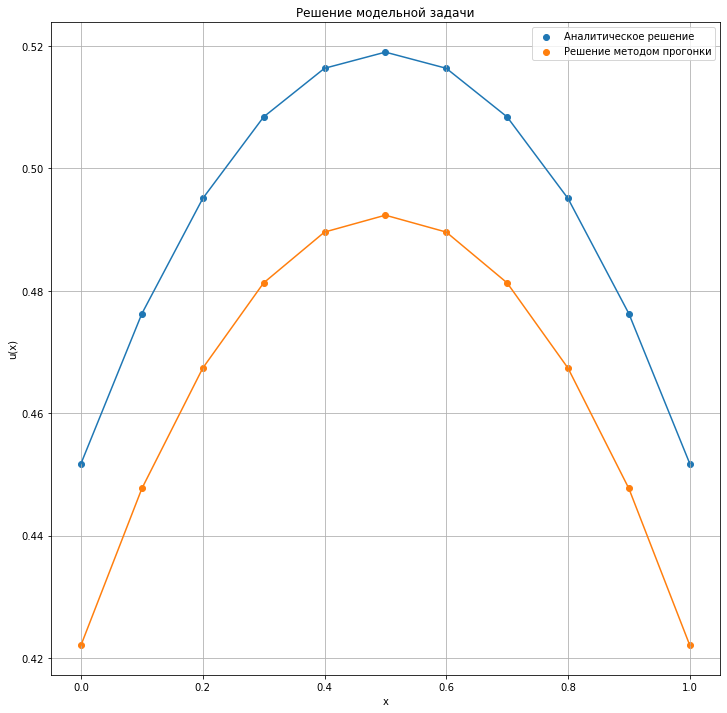

In [7]:
plt.figure(figsize=(12, 12))
plt.scatter(x, u,   label= 'Аналитическое решение')
plt.plot(x, u)
plt.scatter(x, u_l, label= 'Решение методом прогонки')
plt.plot(x, u_l)
plt.grid()
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('Решение модельной задачи')
plt.show()

### 3. Численное решение общей задачи

In [8]:
class Main(Model):
    def __init__(self, L : int = 10):
        self.L = L
        self.h = 1/L
        
    def a(self, x: float) -> float:
        if x == 0:
            return k(0)
        return 0 if x == 1 else k(x + self.h/2)
    
    def b(self, x: float) -> float:
        if x == 0:
            return -k(0) - delta_1*self.h
        return -k(1) - delta_2*self.h if x == 1 else (-1)*( k(x+self.h/2) + k(x-self.h/2) + q(x)*self.h**2 )
    
    def c(self, x: float) -> float:
        if x == 0:
            return 0
        return k(1) if x == 1 else k(x-self.h/2)
    
    def d(self, x : float) -> float:
        if x == 0:
            return -eps_1*self.h
        return -eps_2*self.h if x == 1 else -f(x)*self.h**2
    
    def errors(self, ideal):
        return abs(ideal - self.solve())
    
    def max_error(self, ideal):
        result = max(self.errors(ideal))
        print('Максимальная погрешность при L =', self.L,":", round(result, 6) )
        return result

main       = Main(L)
ideal, u_l = Main(ideal_L).solve(), main.solve()

In [9]:
data  = pd.DataFrame()
data['Значение x'] = x
data['u(x) при L = L'] = u_l
data["u(x) при L = ideal_L"] = ideal
main.max_error(ideal)
data

Максимальная погрешность при L = 10 : 0.033516


,Значение x,u(x) при L = L,u(x) при L = ideal_L
0,0.0,0.395449,0.428965
1,0.1,0.434994,0.467088
2,0.2,0.465382,0.496483
3,0.3,0.487715,0.518199
4,0.4,0.502879,0.533073
5,0.5,0.511576,0.541769
6,0.6,0.514361,0.544806
7,0.7,0.511664,0.542584
8,0.8,0.503821,0.535410
9,0.9,0.491088,0.523519


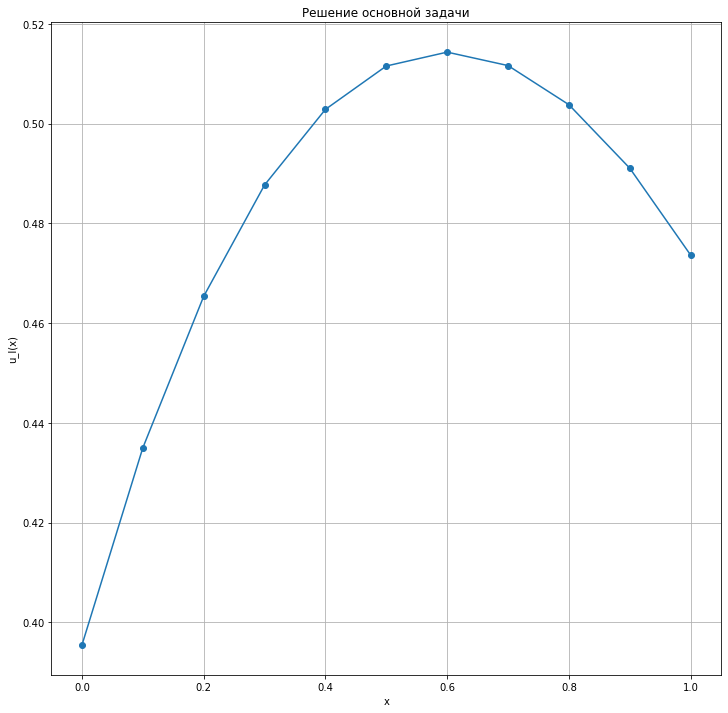

In [10]:
plt.figure(figsize=(12, 12))
plt.plot(x, u_l, marker= "o")
plt.grid()
plt.xlabel('x')
plt.ylabel('u_l(x)')
plt.title('Решение основной задачи')
plt.show()

### 4. Исследование сходимости численного решения

In [11]:
X, Y = [], []

for i in range(ideal_i-5):
    X.append(L*2**i)
    main = Main(X[-1])
    Y.append(main.max_error(ideal))

Максимальная погрешность при L = 10 : 0.033516
Максимальная погрешность при L = 20 : 0.016539
Максимальная погрешность при L = 40 : 0.008215
Максимальная погрешность при L = 80 : 0.004094
Максимальная погрешность при L = 160 : 0.002044
Максимальная погрешность при L = 320 : 0.001021
Максимальная погрешность при L = 640 : 0.00051
Максимальная погрешность при L = 1280 : 0.000255
Максимальная погрешность при L = 2560 : 0.000127
Максимальная погрешность при L = 5120 : 6.4e-05
Максимальная погрешность при L = 10240 : 3.2e-05
Максимальная погрешность при L = 20480 : 1.6e-05
Максимальная погрешность при L = 40960 : 8e-06


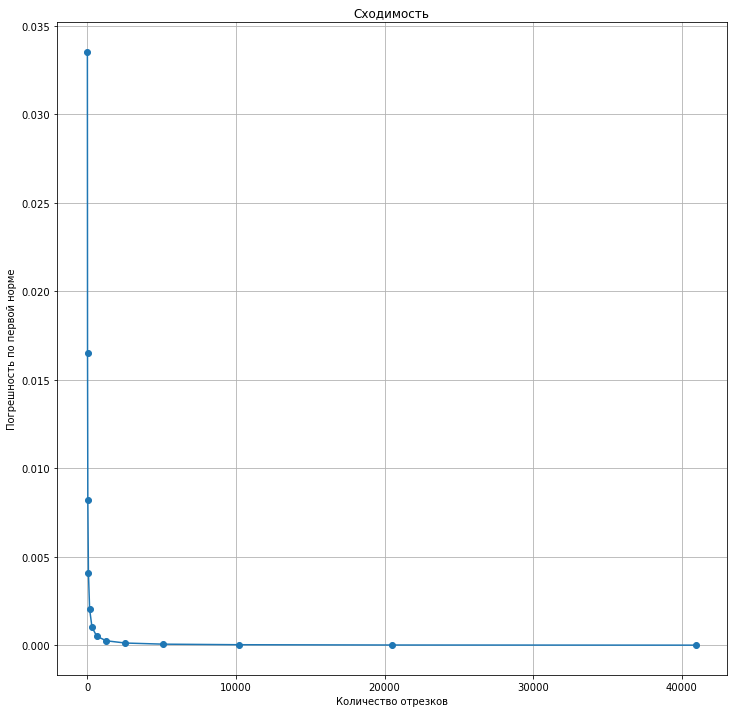

In [12]:
plt.figure(figsize=(12, 12))
plt.plot(X, Y, marker= "o")
plt.grid()
plt.xlabel('Количество отрезков')
plt.ylabel('Погрешность по первой норме')
plt.title('Сходимость')
plt.show()